# Differentiation in Theano vs Sympy

In [1]:
#run below comment to install theano so we can call import theano and whatnot below
! pip install theano

* Zhouming (MingMing) Sun
    * Conceptualization and initial investigation: set up basic framework of project with a differentiation comparision example
* Musaab Al-Bakry
    * Worked on the systematic comparasons between Theano and Sympy differentiation for polynomials
    * Used the time module to measure speed of the module 
* Rebecca Jacobs 
    * Found an undifferentiable function to try and "break" theano differentiation
    * Added a snipped about Tensors in repsonse to an open question from the individual project 


## About the method

I was really interested by symbolic differentiation, so I tried to do it in a more efficient and cleaner way to understand higher order deriviatives on a function with respect to x. 

According to wikipedia: "Theano is a Python library and optimizing compiler for manipulating and evaluating mathematical expressions, especially matrix-valued ones. In Theano, computations are expressed using a NumPy-esque syntax and compiled to run efficiently on either CPU or GPU architectures."

Theano can do derivatives, but it also has the ability to produce computational graphs, as seen in x_squared_derivative.png and x_cubed_derivative.png. So I thought it would be super neat to have it do a higher order derivative, and then give us a computation graph. My goal is to compare symbolic differentiation results between theano and sympy for basic polynomials. 

In [2]:
import numpy
import theano
import theano.tensor as T
from theano import pp

#here is a basic example of taking derivative of x^2
x = T.dscalar('x')
y = x ** 2
gy = T.grad(y, x)
print(pp(gy))  # print out the gradient prior to optimization
print("The derivative is right, once you look past the tensorconstant stuff:   2 * x ^ (2-1)")


f = theano.function([x], gy)

#calculate value of x=4. 2*4 = 8, seems good
print(f(4))

print("final result below in reduced form, it seems. 2x is indeed the derivative of x^2: ")
pp(f.maker.fgraph.outputs[0])
#theano.printing.pydotprint(f, outfile="looped_derivatives.png", var_with_name_simple=True)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


((fill((x ** TensorConstant{2}), TensorConstant{1.0}) * TensorConstant{2}) * (x ** (TensorConstant{2} - TensorConstant{1})))
The derivative is right, once you look past the tensorconstant stuff:   2 * x ^ (2-1)
8.0
final result below in reduced form, it seems. 2x is indeed the derivative of x^2: 


'(TensorConstant{2.0} * x)'

In [3]:
#i want to have a function that derives an expression f_x with respect to x, n times. then print out the computational graph

#takes in a function of x, x data type, and n number of times to derive f_x
#this is my own wack function
def deriv_loop(f_x, x, n):
    dx = f_x
    for i in range(n):
        dx = T.grad(dx, x)
    return dx

#let's first test on x^10, derived 5 times. The answer should be 30240 * x^5
x = T.dscalar('x')
y = x ** 10
g = deriv_loop(y, x, 5)

print(pp(g))
print("wow that looks terrible, but it is before optimization")
print()

h = theano.function([x], g)
print(h(2))
print("yay that is right. 30240 * 2^5 = 967680 indeed")
print()

print("Below is the optimized form. It looks off. IDK what the whole left half is doing. The 30240 is correct though, so it is still somehow right")
pp(h.maker.fgraph.outputs[0])


(((fill((((fill((((fill((((fill(((fill((x ** TensorConstant{10}), TensorConstant{1.0}) * TensorConstant{10}) * (x ** (TensorConstant{10} - TensorConstant{1}))), TensorConstant{1.0}) * (fill((x ** TensorConstant{10}), TensorConstant{1.0}) * TensorConstant{10})) * (TensorConstant{10} - TensorConstant{1})) * (x ** ((TensorConstant{10} - TensorConstant{1}) - TensorConstant{1}))), TensorConstant{1.0}) * ((fill(((fill((x ** TensorConstant{10}), TensorConstant{1.0}) * TensorConstant{10}) * (x ** (TensorConstant{10} - TensorConstant{1}))), TensorConstant{1.0}) * (fill((x ** TensorConstant{10}), TensorConstant{1.0}) * TensorConstant{10})) * (TensorConstant{10} - TensorConstant{1}))) * ((TensorConstant{10} - TensorConstant{1}) - TensorConstant{1})) * (x ** (((TensorConstant{10} - TensorConstant{1}) - TensorConstant{1}) - TensorConstant{1}))), TensorConstant{1.0}) * ((fill((((fill(((fill((x ** TensorConstant{10}), TensorConstant{1.0}) * TensorConstant{10}) * (x ** (TensorConstant{10} - TensorCons

'Elemwise{Composite{(i0 * Composite{(sqr(sqr(i0)) * i0)}(i1))}}(TensorConstant{30240.0}, x)'

In [4]:
#let's see what the computation graph looks like! 
theano.printing.pydotprint(h, outfile="looped_derivatives.png", var_with_name_simple=True)

The output file is available at looped_derivatives.png


After checking out that output file... 
Well that was not what I was looking for. I was hoping for some complex looking loopy graph, but instead it treated 5 derivatives as one operation. It also returned something weird for the final reduced form of the 5th derivative of x^10. However, the test of h(2) returned the correct answer, so it must be doing something right. (I tested several other values and they all seem correct.)

Let's compare this to sympy: 

In [5]:
import sympy
from sympy.abc import x
k = x ** 10
k

x**10

In [6]:
k = sympy.diff(k, x)
k = sympy.diff(k, x)
k = sympy.diff(k, x)
k = sympy.diff(k, x)
k = sympy.diff(k, x)
k

30240*x**5

## Conclusion about this basic comparison

Ok, granted, we did hardcode 5 derivatives for sympy, but still. It is a little embarrassing how easy sympy handled this compared to theano. 

The theano repeated derivative function was also kind of jenky, and that is probably also a major factor as to why the 5th derivative and computation graph looks like pasta. For the case of very simple polynomial symbolic differentiation, a sympy derivative gives a much clearer answer than a theano handicapped with questionable code. 

To explore this further, we will compare calculation times, and test more complex functions that aren't just easy polynomials. Perhaps theano will shine there. 

## Theano and Sympy timing comparasons

In this section, we were trying to find the differences and similarities of running differentaiting functions using both Theano and Sympy. In this section, we will only be looking at polynomials since they are arguably the most important form, and it is possible to appoximate all other functions as polynomials with a reasonable accuracy.

In [7]:
import timeit
import time
import random
import numpy as np
import matplotlib.pyplot as plt

In [8]:
var = T.dscalar('x')
poly_10_th = var**10 + var**9 + var**8 + 1000*var**6
start = time.time()
deriv_loop(poly_10_th, var, 5)
end = time.time()

print(end - start) # in seconds

1.4090065956115723


In [9]:
poly_10 = x**10 + x**9 + x**8 + 1000*x**6

start = time.time()
poly_10 = sympy.diff(poly_10, x)
poly_10 = sympy.diff(poly_10, x)
poly_10 = sympy.diff(poly_10, x)
poly_10 = sympy.diff(poly_10, x)
poly_10 = sympy.diff(poly_10, x)
end = time.time()

print(end - start)

0.200944185256958


Looking at the results from above, we notice that Theano is performing worse than Sympy when it comes to differentiating polynomials. However, after a little or research, we realized that Theano is most efficient when handling large amount of data especially when paired with a GPU calculations. These runs that we performed here are made using CPUs, so it may not be as efficient. Next, we will try to see how does these two methods scale when we use longer polynomials. The following functions are configurable helper functions that we will be using later to compare the polynomial differentiation for both functions.

In [10]:
def theano_polydiff_timer(epochs : int, poly_len : int, diff_num : int, exp_max: int, const_max: float):
    """
    theano_polydiff_timer: runs the Theano function multiple times and returns the average timing per run in seconds
    epochs (int): number of times to run the Theano differentiation
    poly_len (int): the length of the polynomial
    diff_num (int): the number of derivatives taken
    exp_max (int): maximum exponent possible
    const_max (float): maximum constant possible for each term
    """
    timings = []
    for j in range(epochs): # runs the timing for multiple epochs
        poly_rand_th = 0
        random.seed(time.time()) # initialize the RNG seed
        for i in range(poly_len):
            exp = random.randint(0, exp_max)
            const = random.random()
            const = const * const_max # re-scale const to be within range (0, const_max)

            poly_rand_th += const*var**exp

        start = time.time()
        deriv_loop(poly_rand_th, var, diff_num)
        end = time.time()
        
        timings.append(end - start)

    return np.mean(timings) # in seconds

theano_polydiff_timer(20, 50, 1, 700, 1000)

2.6564127922058107

In [11]:
def sympy_polydiff_timer(epochs : int, poly_len : int, diff_num : int, exp_max: int, const_max: float):
    """
    sympy_polydiff_timer: runs the Sympy function multiple times and returns the average timing per run in seconds
    epochs (int): number of times to run the Sympy differentiation
    poly_len (int): the length of the polynomial
    diff_num (int): the number of derivatives taken
    exp_max (int): maximum exponent possible
    const_max (float): maximum constant possible for each term
    """
    timings = []
    for j in range(epochs): # runs the timing for multiple epochs
        poly_rand_sy = 0
        random.seed(time.time()) # initialize the RNG seed
        for i in range(poly_len):
            exp = random.randint(0, exp_max)
            const = random.random()
            const = const * const_max # re-scale const to be within range (0, const_max)

            poly_rand_sy += const*x**exp

        start = time.time()
        poly_rand_sy = sympy.diff(poly_rand_sy, x)
        poly_rand_sy = sympy.diff(poly_rand_sy, x)
        poly_rand_sy = sympy.diff(poly_rand_sy, x)
        poly_rand_sy = sympy.diff(poly_rand_sy, x)
        poly_rand_sy = sympy.diff(poly_rand_sy, x)
        end = time.time()
        
        timings.append(end - start)

    return np.mean(timings) # in seconds

sympy_polydiff_timer(20, 50, 1, 700, 1000)

3.7634368896484376

The following examples will be comparing how the two functions (Theano and Sympy) scale with respect to the length of the polynomials on a regular CPU. **The following cell may take a while to run**.

In [12]:
plot_range = range(10, 100, 5)
theano_timings1 = []
sympy_timings1 = []

for i in plot_range:
    theano_timings1.append(theano_polydiff_timer(5, i, 1, 20, 1000))
    sympy_timings1.append(sympy_polydiff_timer(5, i, 1, 20, 1000))

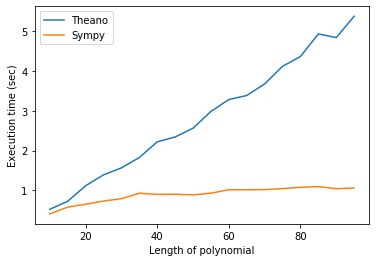

In [13]:
th_plot = plt.plot(plot_range, theano_timings1, label="Theano")
sy_plot = plt.plot(plot_range, sympy_timings1, label="Sympy")
plt.legend()
plt.xlabel("Length of polynomial")
plt.ylabel("Execution time (sec)")
plt.show()

In the previous test, we varied the length of the polynomial from 10 to 100 with steps of 5. We kept the maximum exponent value to be 20 regardless of the polynomial length. This means that some of the terms will have the same exponent, which means that the complexity of the polynomials will reach a maximum near 20 terms. While Sympy method showcases this asymptotic behaviors of the polynomials, Theano differentiation scales linearly with time. This is in a way ironic since Theano boasts about its ability to simplifying complex mathematical expressions, yet adding same-exponent terms before differentiating seems to slip from its mind. Additionally, there a noticable variance in Theano's timings that does not show in Sympy. In the following test, we would like to investigate what would happen if the maximum exponent scaled up with the length of the polynomial, which reduces the number of terms with the same degree.

In [14]:
plot_range = range(10, 100, 5)
theano_timings2 = []
sympy_timings2 = []

for i in plot_range:
    theano_timings2.append(theano_polydiff_timer(5, i, 1, 2*i, 1000))
    sympy_timings2.append(sympy_polydiff_timer(5, i, 1, 2*i, 1000))

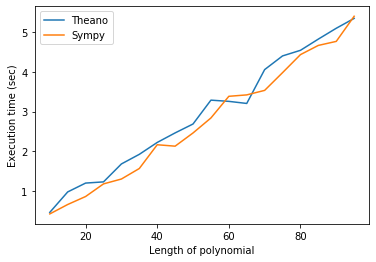

In [15]:
th_plot = plt.plot(plot_range, theano_timings2, label="Theano")
sy_plot = plt.plot(plot_range, sympy_timings2, label="Sympy")
plt.legend()
plt.xlabel("Length of polynomial")
plt.ylabel("Execution time (sec)")
plt.show()

Now that the maximum exponent scales up with the length of the polynomial, we notice both Theano and Sympy times grow linearly with the length of the polynomial and they are comparable now. Then, we tried to compare the Theano with fixed max and with increasing max from the previous two tests to see if the maximum affects the trend considerably.

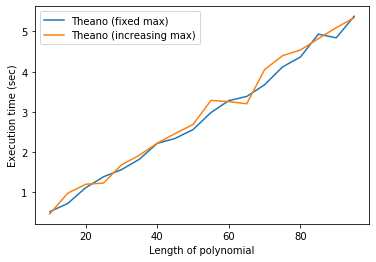

In [16]:
th_plot1 = plt.plot(plot_range, theano_timings1, label="Theano (fixed max)")
th_plot2 = plt.plot(plot_range, theano_timings2, label="Theano (increasing max)")
plt.legend()
plt.xlabel("Length of polynomial")
plt.ylabel("Execution time (sec)")
plt.show()

As shown above, Theano's performance doesn't seem to be affected regardless on whether the maximum exponent is increasing as a function of the length of the polynomial or not. This could be another clue that Theano handles each term on its own regardless of its exponent. This test encourages us to compare the performance of Theano versus Sympy based on the maximum polynomial degree and fixing the length of the polynomial. **The following cell may take awhile to run**.

In [17]:
plot_range = range(10, 700, 5)
theano_timings3 = []
sympy_timings3 = []

for i in plot_range:
    theano_timings3.append(theano_polydiff_timer(5, 5, 1, i, 1000))
    sympy_timings3.append(sympy_polydiff_timer(5, 5, 1, i, 1000))

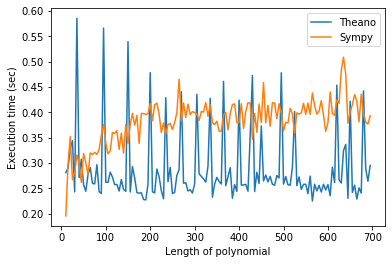

In [18]:
th_plot = plt.plot(plot_range, theano_timings3, label="Theano")
sy_plot = plt.plot(plot_range, sympy_timings3, label="Sympy")
plt.legend()
plt.xlabel("Length of polynomial")
plt.ylabel("Execution time (sec)")
plt.show()

Here we notice that by fixing the length of polynomials and increasing the maximum exponent, Theano remains constant regardless of the exponent value while Sympy increases monotonically and asymptotes as the exponent size increases. We also notice that Theano performs better than Sympy for large exponents. However, Theano shows a weird pattern of spiking periodically, which we cannot explain. This could be due to how Theano stores data if it uses dynamic allocation to solve for additional polynomials.

In [19]:
for i in range(len(theano_timings3)):
    if theano_timings3[i] > 0.05:
        print(plot_range[i])

10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695


Running this test, we notice that the spikes happen almost consistently with a period of 65.

## Trying to Break Theano with different functions 

I was trying to come up with functions that may be costly or take a considerable amount of time to compute in Theanos. However, many deriatives can be computed pretty easily by this software so how about trying to differentiate a function that doesn't actually have a derivative?



## What happens when you try to differentiate a function in Theano that doesn't have a derivative?

I was interested in this concept and came across a function called the Weierstrass function that is continuous everywhere but differentiable nowhere. (neat!) 


## The Weierstrass function:

![](http://pgfplots.net/media/tikz/examples/PDF/weierstrass-function.pdf)





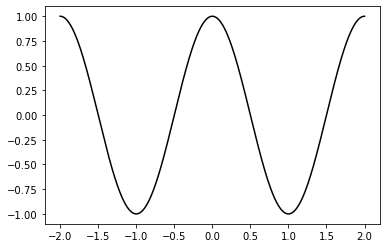

In [20]:
# close up of the approximation

import numpy as nump
import matplotlib.pyplot as plt

m = 100000
k = 10

def wei(x, k):
    y = nump.zeros((1,m))
    for n in range(1,k):
        y = y + nump.cos(1**n*nump.pi*x) / 2**n
    return y

x = nump.linspace(-2,2,m)
y = nump.reshape(wei(x,500), (m,))

plt.plot(x, y, 'k-')
plt.show()

In [21]:
# trying to create / run the Weierstrass function in Theano 

import numpy as nump
import theano
import theano.tensor as T
from theano import pp

x = T.dscalar('x')
# not exactly
y = nump.cos(1**x*nump.pi*x) / 2**x

gy = T.grad(y, x)
print(pp(gy))  # print out the gradient prior to optimization

f = theano.function([x], gy)

print(f(2))
pp(f.maker.fgraph.outputs[0])
print(" ")
print("This function is not quite the Weierstrass becasue it is obviously not in the form of a series, however, I was trying to test what would happen if you create a tensor of the function's series values and take the gradient from there. There were a bunch of errors and I might need more     expertise in tensors/theano before executing it properly, but I am still very interested in the outcome. ")
print(" ")
theano.printing.pydotprint(f, outfile="looped_derivatives.png", var_with_name_simple=True)


((switch(eq(TensorConstant{1}, TensorConstant{0}), TensorConstant{0}, ((((((-(fill((cos((((TensorConstant{1} ** x) * TensorConstant{3.141592653589793}) * x)) / (TensorConstant{2} ** x)), TensorConstant{1.0}) / (TensorConstant{2} ** x))) * sin((((TensorConstant{1} ** x) * TensorConstant{3.141592653589793}) * x))) * x) * TensorConstant{3.141592653589793}) * log(TensorConstant{1})) * (TensorConstant{1} ** x))) + (((-(fill((cos((((TensorConstant{1} ** x) * TensorConstant{3.141592653589793}) * x)) / (TensorConstant{2} ** x)), TensorConstant{1.0}) / (TensorConstant{2} ** x))) * sin((((TensorConstant{1} ** x) * TensorConstant{3.141592653589793}) * x))) * ((TensorConstant{1} ** x) * TensorConstant{3.141592653589793}))) + switch(eq(TensorConstant{2}, TensorConstant{0}), TensorConstant{0}, ((((-(fill((cos((((TensorConstant{1} ** x) * TensorConstant{3.141592653589793}) * x)) / (TensorConstant{2} ** x)), TensorConstant{1.0}) * cos((((TensorConstant{1} ** x) * TensorConstant{3.141592653589793}) * x


## Tensors 
![](https://papers.bastolasushan.com/wp-content/uploads/2019/11/fig0201a.png)

What are tensors?

Tensors are a type of data structure similar to a vector or matrix, but with n-dimensions. You can perform operations on tensors like addition, subtraction, and multiplication, similar to matricies, but they are a bit more involved and get complicated very quickly. 






## About the software

Theano was developed by Montreal Institute for Learning Algorithms (MILA), University of Montreal, up until late 2017

Link to the repository: https://github.com/Theano/Theano 

Official tutorial: http://www.deeplearning.net/software/theano/index.html

Here is their summary from their tutorial: 

Theano is a Python library that allows you to define, optimize, and evaluate mathematical expressions involving multi-dimensional arrays efficiently. Theano features:

* tight integration with NumPy – Use numpy.ndarray in Theano-compiled functions.
* transparent use of a GPU – Perform data-intensive computations much faster than on a CPU.
* efficient symbolic differentiation – Theano does your derivatives for functions with one or many inputs.
* speed and stability optimizations – Get the right answer for log(1+x) even when x is really tiny.
* dynamic C code generation – Evaluate expressions faster.
* extensive unit-testing and self-verification – Detect and diagnose many types of errors.
* Theano has been powering large-scale computationally intensive scientific investigations since 2007. But it is also approachable enough to be used in the classroom (University of Montreal’s deep learning/machine learning classes).
